# Goal
Identify tracks that overperform or underperform relative to their predicted popularity and uncover behavioral or market patterns behind these mismatches.

## 0. Motivation
**Questions**
- Which songs perform better than expected?
- Which songs are overlooked?
- Can we detect hidden gems early?

**Why it matters**
- discovery systems
- playlist curation
- marketing prioritization
- recommendation ranking

## 1. Load Data & Best Model Outputs
**Concept**
We freeze Notebook 05’s best model.

Inputs needed:
- actual popularity
- predicted popularity

**Create**
- predicted_popularity
- residual = actual − predicted

**Interpretation note**
- Residual captures unexplained performance:
- positive → surprise hit
- negative → underperformer

In [95]:
import pandas as pd

In [96]:
df = pd.read_parquet("../data/processed/base_aligned.parquet")

In [97]:
df.head()

,apple_track_id,apple_artist_id,track_name,artist_name,genre,country,release_date,release_year,release_month,release_ym,...,cover_art_url,bpm,energy,brightness,noisiness,rhythm_strength,artist_followers,artist_popularity,artist_genres,artist_image_url
0,298321904,46087,Music,Erick Sermon,Hip-Hop/Rap,USA,2001-08-27 12:00:00+00:00,2001,8,2001-08,...,https://i.scdn.co/image/ab67616d0000b2737276e4...,99.384014,0.164533,1887.936273,0.080000,2.063508,265997.0,52.0,"['east coast hip hop', 'old school hip hop']",https://i.scdn.co/image/ab6761610000e5ebbefe81...
1,80815173,20044,Music,Madonna,Pop,USA,2000-08-21 07:00:00+00:00,2000,8,2000-08,...,https://i.scdn.co/image/ab67616d0000b2734c8f09...,117.453835,0.181498,2826.828547,0.118955,2.087084,117116492.0,96.0,[],https://i.scdn.co/image/ab6761610000e5eb9e5289...
2,169003415,486597,Don't Stop Believin' (2024 Remaster),Journey,Rock,USA,1981-06-03 07:00:00+00:00,1981,6,1981-06,...,https://i.scdn.co/image/ab67616d0000b27370b5c1...,117.453835,0.093140,2063.243547,0.109971,1.150188,6687304.0,76.0,"['aor', 'classic rock']",https://i.scdn.co/image/ab6761610000e5ebe848df...
3,277635828,156987,I'm Yours,Jason Mraz,Pop,USA,2008-02-12 08:00:00+00:00,2008,2,2008-02,...,https://i.scdn.co/image/ab67616d0000b273125b1a...,151.999081,0.172077,1737.766877,0.061636,1.706438,7337242.0,74.0,"['soft pop', 'acoustic pop']",https://i.scdn.co/image/ab6761610000e5ebc3b370...
4,298429596,46087,Music,Erick Sermon,Hip-Hop/Rap,USA,2001-05-29 07:00:00+00:00,2001,5,2001-05,...,https://i.scdn.co/image/ab67616d0000b2737276e4...,99.384014,0.167033,1868.193043,0.078049,2.053480,265997.0,52.0,"['east coast hip hop', 'old school hip hop']",https://i.scdn.co/image/ab6761610000e5ebbefe81...


In [98]:
release_df = (
    df.groupby(["artist_name","release_date"], observed=True)["track_popularity"]
        .max()
        .reset_index()
        .rename(columns={"track_popularity":"release_max_pop"})
)

In [99]:
release_df = release_df.sort_values(["artist_name","release_date"])

release_df["prev_release_pop"] = (
    release_df.groupby("artist_name")["release_max_pop"]
                .shift(1)
)

release_df["prior_release_mean_pop"] = (
    release_df.groupby("artist_name")["prev_release_pop"]
                .expanding()
                .mean()
                .reset_index(level=0, drop=True)
)

In [100]:
df = df.merge(
    release_df[[
        "artist_name",
        "release_date",
        "prev_release_pop",
        "prior_release_mean_pop"
    ]],
    on=["artist_name","release_date"],
    how="left"
)

In [101]:
df_model = df.dropna(subset=['artist_popularity', 'artist_followers',"prev_release_pop"])
df_model.shape

(6729, 34)

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [103]:
X = df_model[['artist_popularity', 'artist_followers','prev_release_pop', 'prior_release_mean_pop']]
y = df_model['track_popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
print(X_train.shape, X_test.shape)

(5383, 4) (1346, 4)


In [104]:
lr = LinearRegression()
lr.fit(X, y)
df_model = df_model.copy()
df_model["predicted_popularity"] = lr.predict(X)

## 2. Residual Analysis (Behavior Gap Signal)

### Why residuals?
Our model estimates **expected popularity** based on known signals:
- artist reputation
- followers
- prior momentum

However, real listener behavior is noisy and influenced by:
- trends
- virality
- timing
- playlist exposure
- social dynamics

Residuals capture this gap:

residual = actual − predicted

Interpretation:
- positive → song performed better than expected (surprise hit)
- negative → song underperformed (underrated or missed opportunity)
- near 0 → performance aligned with expectations

We will use residuals to discover hidden patterns and market mismatches.


In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
df_model = df_model.copy()

df_model["residual"] = (
    df_model["track_popularity"] 
    - df_model["predicted_popularity"]
)

### Sanity Check

Before deeper analysis, verify:
- residual mean ≈ 0
- reasonable spread
- no extreme broken values

If residuals look wrong, the prediction step likely has an issue.

In [107]:
df_model["residual"].describe()

count    6.729000e+03
mean     4.189974e-15
std      1.587619e+01
min     -6.182143e+01
25%     -9.508099e+00
50%      8.082309e-01
75%      1.141001e+01
max      5.411127e+01
Name: residual, dtype: float64

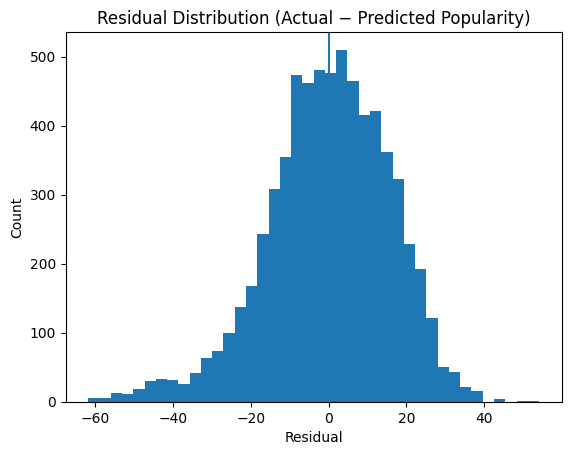

In [108]:
plt.hist(df_model["residual"], bins=40)
plt.axvline(0)
plt.title("Residual Distribution (Actual − Predicted Popularity)")
plt.xlabel("Residual")
plt.ylabel("Count")

plt.show()

Even after controlling for artist reputation and momentum, substantial unexplained variance remains, suggesting that listener behavior and market dynamics play a large role in determining success.

## 3. Segment Tracks by Performance

Residuals measure how much each song deviates from expectations.

To make interpretation easier, we segment tracks into categories:

- Surprise Hits: performed much better than expected
- Expected: performed close to predictions
- Underrated: performed much worse than expected

This segmentation helps us:
- identify hidden gems
- detect missed opportunities
- understand behavioral or market anomalies


In [109]:
def segment_track(r):
    if r >= 20:
        return "surprise_hit"
    elif r <= -20:
        return "underrated"
    else:
        return "expected"

df_model["segment"] = df_model["residual"].apply(segment_track)

### Segment Sizes

We check how many tracks fall into each category to understand
how common large market mismatches are.

In [110]:
df_model["segment"].value_counts(normalize=True)

segment
expected        0.810373
underrated      0.096745
surprise_hit    0.092882
Name: proportion, dtype: float64

## 4. Underrated Track Analysis

Underrated tracks are songs that our model expected to perform well
(based on artist reputation and prior momentum) but actually performed poorly.

These represent potential:
- missed opportunities
- poor exposure
- niche audiences
- marketing failures

Understanding their shared traits may reveal:
- structural blind spots in discovery systems
- segments that are underserved


In [111]:
underrated_df = df_model[df_model["segment"] == "underrated"]

In [112]:
underrated_df.shape

(651, 37)

### Compare Underrated vs Overall

We compare summary statistics to understand:
Do underrated songs systematically differ in artist strength, genre, or audio traits?

In [113]:
features = ['artist_popularity', 'artist_followers','prev_release_pop',
            'prior_release_mean_pop', 'track_popularity']

means = underrated_df[features].mean().round(3)

print("=== Underrated ===")
for name, value in means.items():
    print(f"{name}: {value:,.3f}")

=== Underrated ===
artist_popularity: 74.536
artist_followers: 13,619,260.813
prev_release_pop: 53.544
prior_release_mean_pop: 53.923
track_popularity: 18.711


In [114]:
overall_means = df_model[features].mean().round(3)

print("=== Overall ===")
for name, value in overall_means.items():
    print(f"{name}: {value:.3f}")

=== Overall ===
artist_popularity: 75.202
artist_followers: 16109093.814
prev_release_pop: 56.779
prior_release_mean_pop: 56.831
track_popularity: 51.139


### Investigating Why Strong Artists Still Underperform

Since underrated tracks have similar artist strength to the overall dataset,
their poor performance is unlikely due to reputation.

This suggests contextual or exposure-related factors such as:
- non-title tracks
- less playlist placement
- niche genres
- longer/less radio-friendly songs
- release timing effects

Next, we examine genre and audio characteristics to identify patterns.

In [115]:
print("=== Underrated ===")
underrated_df["genre"].value_counts(normalize=True).head(10)

=== Underrated ===


genre
Pop                 0.221198
Country             0.181260
Alternative         0.121352
Rock                0.118280
Hip-Hop/Rap         0.086022
Hard Rock           0.050691
R&B/Soul            0.046083
Classical           0.041475
Children's Music    0.027650
Metal               0.026114
Name: proportion, dtype: float64

In [116]:
print("=== Overall ===")
df_model["genre"].value_counts(normalize=True).head(10)

=== Overall ===


genre
Pop                  0.242830
Country              0.161540
Rock                 0.136276
Alternative          0.126022
Hip-Hop/Rap          0.101204
Hard Rock            0.065983
R&B/Soul             0.038193
Soundtrack           0.024669
Singer/Songwriter    0.014712
Christian            0.014564
Name: proportion, dtype: float64

In [117]:
u = underrated_df["genre"].value_counts(normalize=True)
o = df_model["genre"].value_counts(normalize=True)

compare = (
    pd.concat([u, o], axis=1, keys=["underrated", "overall"])
    .fillna(0)
)

compare["diff"] = compare["underrated"] - compare["overall"]

compare.sort_values("diff", ascending=False).head(10)

,underrated,overall,diff
genre,,,
Classical,0.041475,0.006390,0.035084
Children's Music,0.027650,0.005201,0.022448
Country,0.181260,0.161540,0.019720
Metal,0.026114,0.014118,0.011996
R&B/Soul,0.046083,0.038193,0.007890
Fitness & Workout,0.009217,0.001337,0.007879
Holiday,0.012289,0.006242,0.006047
Psychedelic,0.003072,0.000297,0.002775
Pop Latino,0.003072,0.001783,0.001289
